공부하는 내용
https://www.youtube.com/watch?v=BJwcMFAKqXo

In [62]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import *

In [63]:
vgg16 = VGG16(weights = 'imagenet',
              input_shape=(32,32,3), include_top = False)
# MobileNet(weights = None, input_shape=None, include_top = True)
# ResNet50(weights = None, input_shape=None, include_top = True)
# Xception(weights = None, input_shape=None, include_top = True)

In [64]:
model = Sequential()
model.add(vgg16)

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                2570      
                                                      

In [65]:
import telnetlib as tf
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D, Input, Dropout, Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

import os
import zipfile
import matplotlib.image as mping
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

https://velog.io/@gggggeun1/google-colab-%EC%9D%B4%EC%9A%A9%ED%95%98%EA%B8%B0a

In [66]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /content/cats_and_dogs_filtered.zip

--2022-07-01 18:07:37--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 142.250.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M   123MB/s    in 0.5s    

2022-07-01 18:07:38 (123 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [67]:
local_zip = '/content/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [68]:
base_dir = '/content/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [69]:
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
 
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

In [70]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

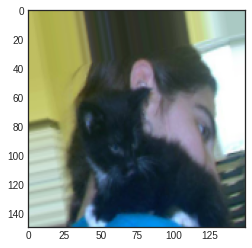

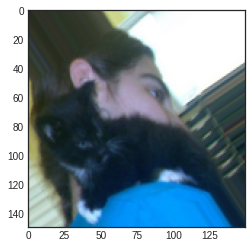

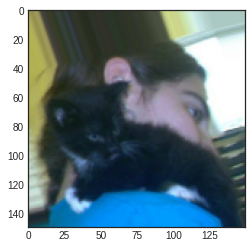

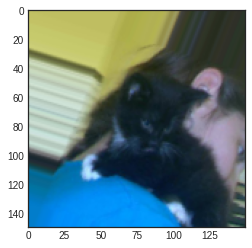

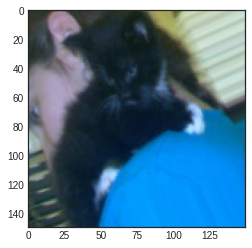

In [71]:
img_path = os.path.join(train_cats_dir, train_cat_fnames[2])
img = load_img(img_path, target_size=(150,150))
x = img_to_array(img)
x = x.reshape((1,)+ x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i+=1
  if i %5==0:
    break

## 학습, 검증 데이터셋의 data Generator

In [72]:
train_datagen = ImageDataGenerator(
    # Normalization -> Normalization을 통해서 data의 scale을  동일하게 만들어 주는데 이는 gradient가 원활하게 업데이트되도록 해준다
    # 모델은 정수를 처리하는것보다 0~1 사이의 실수를 처리할 때 더 좋은 성능을 보이기 때문에0~255의 픽셀값으로 이루어진 이미지에 255를 나눠줘 전처리를 해준다.
    # 장점: Unnormalized한 데이터는 최적값 도달이 복잡하지만, Normalized의 경우에는 쉽게 최적값에 도달할 수 있으며 빠르게 훈련시킬 수 있다.
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## 모델 구성 및 compile

Convolutional Layer에서 나온 Feature map의 값을 샘플링해서 정보를 압축하는 과정이다.
- pool_size : 수직, 수평 축소 비율. (2, 2)이면 출력 이미지의 크기는 입력 이미지 크기의 반이 된다.
- strides : pooling filter를 이동시키는 간격. strides를 지정해주지 않으면, pooling - filter의 크기와 같아서 영역의 오버랩 없이 pooling이 이루어진다.
padding : "valid" or "same" 값을 입력받는다. Conv2D에서의 "valid"와 "same"과 의미가 같다. stride 값이 2이상 일 때 이미지의 모서리에서 데이터가 끝나는 경우, "valid"에서는 해당 데이터가 버려지지만, "same"의 경우 데이터가 없는 부분에 zero-padding을 통해 데이터의 손실을 막는다.
- data_format : "channels_last" or "channels_first" 값을 입력받는다. 

padding : 경계 처리 방법.
- ‘valid’ : 유효한 영역만 출력하기 때문에 출력 이미지 사이즈는 입력 이미지 사이즈보다 작다.
- ‘same’ : 입력 이미지 사이즈와 출력 이미지 사이즈를 동일하게 출력한다.

activation : 활성화 함수.
- ‘linear’ : 디폴트 값으로 입력 뉴런과 가중치로 계산된 결과값이 그대로 출력.
- ‘relu’ : 은익층에 주로 사용. 원리는 활성화함수 참고.
- ‘sigmoid’ : 이진 분류 문제에서 출력층에 주로 사용. 원리는 활성화함수 참고.
-‘softmax’ : 다중 클래스 분류 문제에서 출력층에 주로 사용. 원리는 Loss Funtion 참고.

가장 일반적으로 쓰이는 방법은 MaxPooling으로, 필터가 슬라이딩하며 필터 안에 가장 큰 값을 고르는 방법을 의미한다. 이는 뉴런이 가장 큰 신호에 반응하는 것과 유사한 방법을 이용한 것인데, 인접 픽셀들 간의 유사도가 매우 높다는 이미지 데이터의 특징을 이용하여 선택 영역에서 가장 큰 값을 해당 영역의 대표값으로 설정!

### 수학적 이해
(W=가로, H=세로, D=깊이, Pooling Layer 필터크기 =F, 보폭 = S)
input size =  W_1*H_1*D_1W 
1
​
 ∗H 
1
​
 ∗D 
1
​
  일때,

output size = W_2*H_2*D_2W 
2
​
 ∗H 
2
​
 ∗D 
2
​
 
W_2 = (W_1-F)/S + 1W 
2
​
 =(W 
1
​
 −F)/S+1
H_2 = (H_1-F)/S + 1H 
2
​
 =(H 
1
​
 −F)/S+1
D_2 = KD 
2
​
 =K(W=가로, H=세로, D=깊이, Pooling Layer 필터크기 =F, 보폭 = S)
input size =  W_1*H_1*D_1W 
1
​
 ∗H 
1
​
 ∗D 
1
​
  일때,

output size = W_2*H_2*D_2W 
2
​
 ∗H 
2
​
 ∗D 
2
​
 
W_2 = (W_1-F)/S + 1W 
2
​
 =(W 
1
​
 −F)/S+1
H_2 = (H_1-F)/S + 1H 
2
​
 =(H 
1
​
 −F)/S+1
D_2 = KD 
2
​
 =K

### Loss
- mean_squared_error : 회귀 문제
- categorical_crossentropy : 다중 클래스 분류
- sparse_categorical_crossentropy : 다중 클래스 분류
- categorical_crossentropy와 다르게 레이블을 One-Hot Encoding하지 않고 정수 인코딩 된 상태에서 사용
- binary_crossentropy : 이진 분류

In [73]:
model = Sequential()
model.add(Conv2D(32,(3,3), activation='relu', input_shape=(150,150,3)))
'''
- 32는 filter의 수. filter는 이미지에서 feature을 분리해내는 기능을 하며 filter의 값은 convolution에 사용되는 filter의 개수이며, 출력 공간의 깊이를 결정
filter의 개수를 증가시키면 상세 정보는 손실되지만 일반적인 특징을 찾을 수 있다는 장점이 있다.

- (3,3)는 convolution에 사용되는 filter의 크기

-input_shape=(150,150,3)는 샘플 수를 제외한 입력 형태를 정의. 모델에서 첫 layer일 때만 필요하다. 
(행, 열, 채널 수)로 나타내는데 흑백 이미지인 경우에는 채널이 1이고, 컬러(RGB) 이미지인 경우에는 채널을 3으로 설정한다.
'''
model.add(MaxPool2D(2,2))
'''MaxPool2D(2,2)
Convolutional Layer에서 나온 Feature map의 값을 샘플링해서 정보를 압축하는 과정
pool_size : 수직, 수평 축소 비율. (2, 2)이면 출력 이미지의 크기는 입력 이미지 크기의 반이 됨.
'''
model.add(Conv2D(64,(3,3), activation='relu', input_shape=(150,150,3)))
model.add(MaxPool2D(2,2))
model.add(Conv2D(128,(3,3), activation='relu', input_shape=(150,150,3)))
model.add(MaxPool2D(2,2))
model.add(Conv2D(128,(3,3), activation='relu', input_shape=(150,150,3)))
model.add(MaxPool2D(2,2))
model.add(Flatten())
model.add(Dropout(0.5)) # 네트워크가 과적합되는 경우를 방지하기 위해서 Dropout Layer이용
'''
Convolution Layer와 Pooling Layer를 통과하며 출력된 값에는 주요 특징만 추출되는데 이 특징은 2차원 데이터로 이루어져 있다. 
Dense Layer에서는 1차원 데이터로 바꾸어서 학습이 되어야 하기 때문에 Flatten Layer를 거쳐 2차원 데이터를 1차원 데이터로 바꾼다.
'''
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['acc'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 128)     

### 최적화(optimizer)

- SGD : loss의 값이 최소가 되는 방향으로 가중치를 업데이트하는 방법으로 계속 반복해서 optimization을 진행한다. 기울기 변화가 작은 부분에서는 매우 느리게 이동하는 문제가 발생한다. 또한 Mini-Batch Gradient Descent의 경우 미니배치마다 loss를 계산하여 최적화를 진행하는데 이는 매우 비효율적이다. noise가 발생하면 optimization의 성능이 저하된다.

- ADAM : First moment와 second moment를 이용해 이전 정보를 유지하고 gradients의 제곱을 이용하는 방법이다. 이때 First moment는 velocity를 담당한다. 그리고 second moment는 AdaGrad이나 RMSProp처럼 gradient 제곱 활용한다. 간단하게 구현할 수 있으면 효율적으로 계산하기 때문에 메모리를 많이 사용하지 않는다. 최적의 gradient를 찾을 때 적절한 속도와 방향으로 움직이므로 다른 optimizer들보다 성능이 좋다.

## 모델 학습 및 학습 과정 시각화

batch size가 너무 크면 처리해야할 양이 많다는 것을 의미하므로 학습 속도가 느려지고, 어떤 경우에는 메모리 부족 문제가 나타날 수 있다. 반면 batch size가 너무 작으면 가중치가 자주 업데이트되기 때문에 비교적 불안정하게 훈련이 진행된다. 따라서 배치 사이즈를 바꿔가면서 언제 모델이 가장 효율적으로 훈련되는지 확인해야 한다.

In [74]:
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30, # 전체 트레이닝 데이터가 신경망을 통과한 횟수 즉 총 훈련 횟수
                    # 너무 많이 학습하면 overfitting 문제가 발생한다. 따라서 좋은 결과값이 나오면 epochs수가 남아있더라도 종료시키는 early stopping 방법을 이용하는 걸 추천한다.
                    batch_size=256,
                    validation_data = validation_generator,
                    validation_steps=50,
                    verbose=2)

Epoch 1/30
100/100 - 18s - loss: 0.6930 - acc: 0.5135 - val_loss: 0.6865 - val_acc: 0.5440 - 18s/epoch - 181ms/step
Epoch 2/30
100/100 - 17s - loss: 0.6842 - acc: 0.5510 - val_loss: 0.6639 - val_acc: 0.5760 - 17s/epoch - 171ms/step
Epoch 3/30
100/100 - 17s - loss: 0.6730 - acc: 0.5660 - val_loss: 0.6432 - val_acc: 0.6500 - 17s/epoch - 175ms/step
Epoch 4/30
100/100 - 17s - loss: 0.6499 - acc: 0.6055 - val_loss: 0.6640 - val_acc: 0.5840 - 17s/epoch - 169ms/step
Epoch 5/30
100/100 - 17s - loss: 0.6326 - acc: 0.6390 - val_loss: 0.5809 - val_acc: 0.6930 - 17s/epoch - 171ms/step
Epoch 6/30
100/100 - 17s - loss: 0.6131 - acc: 0.6575 - val_loss: 0.5706 - val_acc: 0.6930 - 17s/epoch - 169ms/step
Epoch 7/30
100/100 - 17s - loss: 0.5880 - acc: 0.6765 - val_loss: 0.5858 - val_acc: 0.6950 - 17s/epoch - 172ms/step
Epoch 8/30
100/100 - 17s - loss: 0.5813 - acc: 0.6925 - val_loss: 0.5488 - val_acc: 0.7220 - 17s/epoch - 171ms/step
Epoch 9/30
100/100 - 17s - loss: 0.5950 - acc: 0.6730 - val_loss: 0.5429

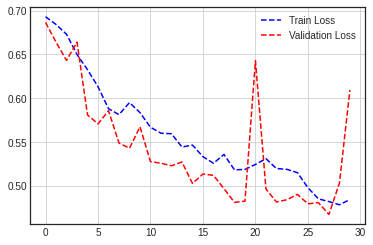

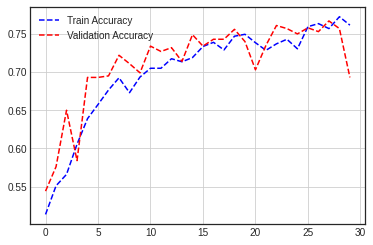

In [75]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs= range(len(acc))

plt.plot(epochs, loss, 'b--', label='Train Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'b--', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.grid()
plt.legend()

plt.show()

## 모델 저장하기

In [76]:
model.save("cats_and_dogs_model.h5")

## 사전 훈련된 모델 사용

In [ ]:
# 미리 저장된 VGG16 model을 이용한다
conv_base = VGG16(weights = 'imagenet',
              input_shape=(150,150,3), include_top = False)

In [78]:
from tensorflow.keras.optimizers import RMSprop

def build_model_with_pretrained(conv_base):
  model = Sequential()
  model.add(conv_base)
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=2e-5),
                metrics=['accuracy'])
  
  return model

### parameter 수 확인하기

In [79]:
model = build_model_with_pretrained(conv_base)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 256)               2097408   
                                                                 
 dense_13 (Dense)            (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


### 레이어 동결
- 훈련하기 전 합성곱 기반 레이어들의 가중치 학습을 막기 위해 이를 동결한다.

In [80]:
print(len(model.trainable_weights))

30


In [81]:
conv_base.trainable=False
print(len(model.trainable_weights))

4


### 모델 컴파일
- trainable 속성을 변경했기 때문에 다시 모델을 컴파일 해야한다.

In [82]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])

## 이미지 제너레이터

In [83]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### 모델 재학습

In [84]:
history2 = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    batch_size=256,
                    validation_data = validation_generator,
                    validation_steps=50,
                    verbose=2)

Epoch 1/30
100/100 - 20s - loss: 0.5996 - accuracy: 0.6860 - val_loss: 0.4529 - val_accuracy: 0.8130 - 20s/epoch - 203ms/step
Epoch 2/30
100/100 - 19s - loss: 0.4826 - accuracy: 0.7785 - val_loss: 0.3835 - val_accuracy: 0.8370 - 19s/epoch - 191ms/step
Epoch 3/30
100/100 - 19s - loss: 0.4307 - accuracy: 0.8085 - val_loss: 0.3642 - val_accuracy: 0.8250 - 19s/epoch - 191ms/step
Epoch 4/30
100/100 - 19s - loss: 0.4016 - accuracy: 0.8175 - val_loss: 0.3206 - val_accuracy: 0.8580 - 19s/epoch - 192ms/step
Epoch 5/30
100/100 - 19s - loss: 0.3890 - accuracy: 0.8285 - val_loss: 0.3028 - val_accuracy: 0.8700 - 19s/epoch - 191ms/step
Epoch 6/30
100/100 - 19s - loss: 0.3593 - accuracy: 0.8495 - val_loss: 0.3225 - val_accuracy: 0.8540 - 19s/epoch - 191ms/step
Epoch 7/30
100/100 - 19s - loss: 0.3713 - accuracy: 0.8285 - val_loss: 0.2880 - val_accuracy: 0.8770 - 19s/epoch - 190ms/step
Epoch 8/30
100/100 - 19s - loss: 0.3550 - accuracy: 0.8430 - val_loss: 0.2786 - val_accuracy: 0.8800 - 19s/epoch - 190

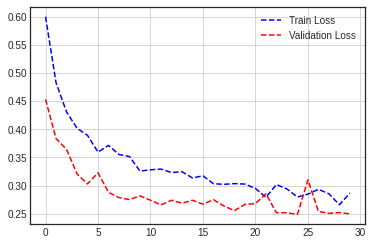

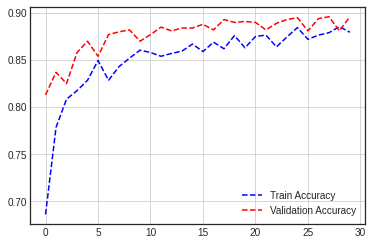

In [85]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs= range(len(acc))

plt.plot(epochs, loss, 'b--', label='Train Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'b--', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.grid()
plt.legend()

plt.show()

In [86]:
model.save('cats_and_dogs_with_pretrained_model.h5')

## 모델 구성

In [90]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

In [88]:
model = load_model('/content/cats_and_dogs_model.h5')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 128)     

In [91]:
img_path = '/content/cats_and_dogs_filtered/validation/dogs/dog.2000.jpg'

img = image.load_img(img_path, target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = img_tensor[np.newaxis,...]
img_tensor /=255.
print(img_tensor.shape)

(1, 150, 150, 3)


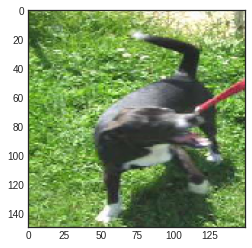

In [109]:
plt.imshow(img_tensor[0])
plt.show()

In [93]:
conv_output = [layer.output for layer in model.layers[:8]]
conv_output

[<KerasTensor: shape=(None, 148, 148, 32) dtype=float32 (created by layer 'conv2d_8')>,
 <KerasTensor: shape=(None, 74, 74, 32) dtype=float32 (created by layer 'max_pooling2d_8')>,
 <KerasTensor: shape=(None, 72, 72, 64) dtype=float32 (created by layer 'conv2d_9')>,
 <KerasTensor: shape=(None, 36, 36, 64) dtype=float32 (created by layer 'max_pooling2d_9')>,
 <KerasTensor: shape=(None, 34, 34, 128) dtype=float32 (created by layer 'conv2d_10')>,
 <KerasTensor: shape=(None, 17, 17, 128) dtype=float32 (created by layer 'max_pooling2d_10')>,
 <KerasTensor: shape=(None, 15, 15, 128) dtype=float32 (created by layer 'conv2d_11')>,
 <KerasTensor: shape=(None, 7, 7, 128) dtype=float32 (created by layer 'max_pooling2d_11')>]

In [95]:
activation_model = Model(inputs=[model.input], outputs=conv_output)

In [96]:
activations = activation_model.predict(img_tensor)

In [97]:
len(activations)

8

## 시각화

(1, 148, 148, 32)


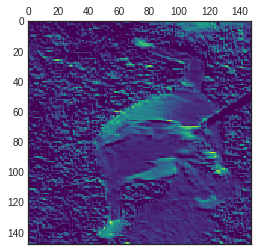

In [106]:
print(activations[0].shape)
plt.matshow(activations[0][0,:,:,0], cmap='viridis')
plt.show()

(1, 148, 148, 32)


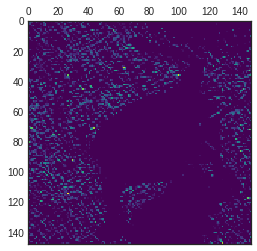

In [101]:
print(activations[0].shape)
plt.matshow(activations[0][0,:,:,2], cmap='viridis')
plt.show()

(1, 148, 148, 32)


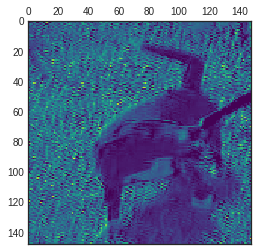

In [105]:
print(activations[0].shape)
plt.matshow(activations[0][0,:,:,6], cmap='viridis')
plt.show()

(1, 148, 148, 32)


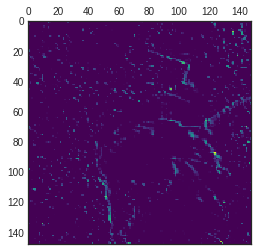

In [103]:
print(activations[0].shape)
plt.matshow(activations[0][0,:,:,20], cmap='viridis')
plt.show()

### 중간의 모든 활성화에 대해 시각화

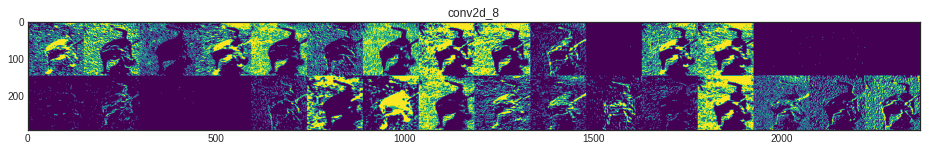

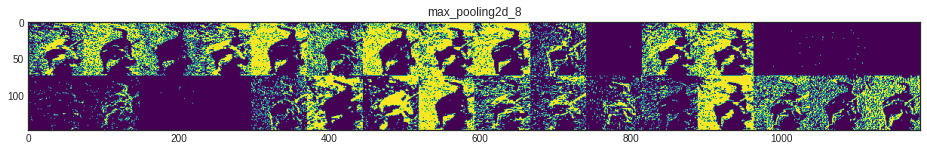

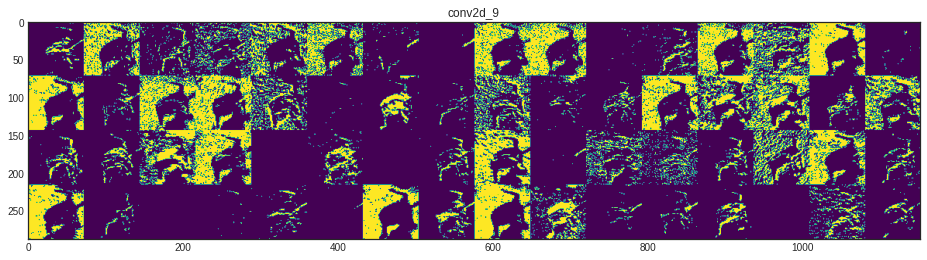

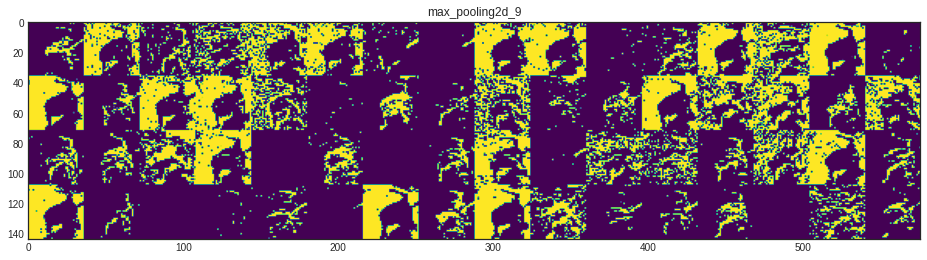

In [110]:
layer_names = []
for layer in model.layers[:4]:
  layer_names.append(layer.name)

images_per_row =16

for layer_name, layer_activation in zip(layer_names, activations):
  num_features = layer_activation.shape[-1]

  size = layer_activation.shape[1]

  num_cols = num_features // images_per_row
  display_grid = np.zeros((size* num_cols, images_per_row * size))

  for col in range(num_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0,:,:, col* images_per_row + row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image *= 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col* size: (col+1) * size, row * size : (row+1)* size] = channel_image

  scale = 1./size

  plt.figure(figsize=(scale* display_grid.shape[1],
                      scale* display_grid.shape[0]))   

  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()